In [10]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up path to data
DATA_PATH = Path("../data/dapo-kemdikdasmen/Jawa-Timur")
print(f"Data path: {DATA_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")

Data path: ..\data\dapo-kemdikdasmen\Jawa-Timur
Data path exists: True


# Analisis Persentase Fasilitas Sekolah - Jawa Timur

## Metode Perhitungan yang Digunakan:

### **PERUBAHAN METODE: BEFORE + AFTER**
Kode ini telah dimodifikasi untuk menggunakan **penjumlahan nilai BEFORE dan AFTER** untuk setiap jenis fasilitas, bukan hanya nilai AFTER saja.

### **Formula Perhitungan:**
1. **Total Fasilitas per Sekolah:** `Total = Before + After`
2. **Persentase per Fasilitas:** `(Total_Sekolah / Max_Total_Semua_Sekolah) × 100%`  
3. **Overall Score:** `Rata-rata dari semua persentase fasilitas`

### **Contoh Perhitungan:**
```
Sekolah A:
- Before ruang_kelas: 8, After ruang_kelas: 4 → Total: 12
- Max ruang_kelas di semua sekolah: 15
- Persentase: (12/15) × 100% = 80%
```

### **Keuntungan Metode Ini:**
- Menghitung **total kapasitas fasilitas** (existing + tambahan)
- Memberikan gambaran **kondisi fasilitas saat ini** secara menyeluruh
- Lebih akurat untuk menilai **kelengkapan infrastruktur** sekolah

In [11]:
def load_all_facility_data(data_path):
    """
    Load all facility data from JSON files in the directory structure
    """
    all_data = []
    
    # Walk through all kabupaten/kota folders
    for kabupaten_folder in data_path.iterdir():
        if kabupaten_folder.is_dir():
            print(f"Processing: {kabupaten_folder.name}")
            
            # Walk through all kecamatan folders
            for kecamatan_folder in kabupaten_folder.iterdir():
                if kecamatan_folder.is_dir():
                    
                    # Walk through all JSON files (schools)
                    for json_file in kecamatan_folder.glob("*.json"):
                        try:
                            with open(json_file, 'r', encoding='utf-8') as f:
                                school_data = json.load(f)
                                
                            # Add metadata
                            for record in school_data:
                                record['kabupaten'] = kabupaten_folder.name
                                record['kecamatan'] = kecamatan_folder.name
                                record['sekolah'] = json_file.stem
                                all_data.append(record)
                                
                        except Exception as e:
                            print(f"Error reading {json_file}: {e}")
    
    return all_data

# Load all data
print("Loading facility data...")
facility_data = load_all_facility_data(DATA_PATH)
print(f"Total records loaded: {len(facility_data)}")

# Convert to DataFrame
df = pd.DataFrame(facility_data)
print(f"DataFrame shape: {df.shape}")
print("\nFirst few columns:")
print(df.columns.tolist()[:10])

Loading facility data...
Processing: Kab. Bangkalan
Processing: Kab. Banyuwangi
Processing: Kab. Blitar
Processing: Kab. Bojonegoro
Processing: Kab. Bondowoso
Processing: Kab. Gresik
Processing: Kab. Jember
Processing: Kab. Jombang
Processing: Kab. Kediri
Processing: Kab. Lamongan
Processing: Kab. Lumajang
Processing: Kab. Madiun
Processing: Kab. Magetan
Processing: Kab. Malang
Processing: Kab. Mojokerto
Processing: Kab. Nganjuk
Processing: Kab. Ngawi
Processing: Kab. Pacitan
Processing: Kab. Pamekasan
Processing: Kab. Pasuruan
Processing: Kab. Ponorogo
Processing: Kab. Probolinggo
Processing: Kab. Sampang
Processing: Kab. Sidoarjo
Processing: Kab. Situbondo
Processing: Kab. Sumenep
Processing: Kab. Trenggalek
Processing: Kab. Tuban
Processing: Kab. Tulungagung
Processing: Kota Batu
Processing: Kota Blitar
Processing: Kota Kediri
Processing: Kota Madiun
Processing: Kota Malang
Processing: Kota Mojokerto
Processing: Kota Pasuruan
Processing: Kota Probolinggo
Processing: Kota Surabaya
To

In [12]:
def calculate_facility_percentages(df):
    """
    Calculate facility percentages based on 'before + after' values
    Logic: (current_count / max_count) * 100% per criteria
    """
    
    # Define facility types (without before/after prefix)
    facility_types = [
        'ruang_kelas',
        'ruang_perpus', 
        'ruang_lab',
        'ruang_praktik',
        'ruang_pimpinan',
        'ruang_guru',
        'ruang_ibadah',
        'ruang_uks',
        'toilet',
        'gudang',
        'ruang_sirkulasi',
        'tempat_bermain_olahraga',
        'ruang_tu',
        'ruang_konseling',
        'ruang_osis',
        'bangunan'
    ]
    
    # Calculate statistics for each facility
    facility_stats = {}
    
    for facility_type in facility_types:
        before_col = f'before_{facility_type}'
        after_col = f'after_{facility_type}'
        
        if before_col in df.columns and after_col in df.columns:
            # Calculate total facilities (before + after)
            df[f'total_{facility_type}'] = df[before_col].fillna(0) + df[after_col].fillna(0)
            
            # Get current counts (filter out null values)
            current_counts = df[f'total_{facility_type}'].dropna()
            
            # Calculate statistics
            max_count = current_counts.max() if len(current_counts) > 0 else 0
            min_count = current_counts.min() if len(current_counts) > 0 else 0
            mean_count = current_counts.mean() if len(current_counts) > 0 else 0
            total_facilities = current_counts.sum() if len(current_counts) > 0 else 0
            total_schools = len(current_counts)
            
            # Calculate percentage based on max value
            if max_count > 0:
                percentages = (current_counts / max_count) * 100
                avg_percentage = percentages.mean()
            else:
                avg_percentage = 0
            
            facility_stats[f'total_{facility_type}'] = {
                'facility_name': facility_type.replace('_', ' ').title(),
                'total_facilities': total_facilities,
                'total_schools': total_schools,
                'max_count': max_count,
                'min_count': min_count,
                'mean_count': mean_count,
                'avg_percentage_vs_max': avg_percentage,
                'schools_with_facility': len(current_counts[current_counts > 0]),
                'schools_without_facility': len(current_counts[current_counts == 0])
            }
    
    return facility_stats

# Calculate facility percentages
print("Calculating facility percentages (BEFORE + AFTER)...")
facility_percentages = calculate_facility_percentages(df)

# Display results
print("\n" + "="*80)
print("FACILITY PERCENTAGE ANALYSIS (BEFORE + AFTER VALUES)")
print("="*80)

for facility, stats in facility_percentages.items():
    print(f"\n{stats['facility_name']}:")
    print(f"  Total facilities across all schools: {stats['total_facilities']}")
    print(f"  Total schools analyzed: {stats['total_schools']}")
    print(f"  Maximum facilities in a single school: {stats['max_count']}")
    print(f"  Average facilities per school: {stats['mean_count']:.2f}")
    print(f"  Average percentage vs maximum: {stats['avg_percentage_vs_max']:.2f}%")
    print(f"  Schools with this facility: {stats['schools_with_facility']}")
    print(f"  Schools without this facility: {stats['schools_without_facility']}")
    print(f"  Facility availability rate: {(stats['schools_with_facility']/stats['total_schools']*100):.2f}%")

Calculating facility percentages (BEFORE + AFTER)...

FACILITY PERCENTAGE ANALYSIS (BEFORE + AFTER VALUES)

Ruang Kelas:
  Total facilities across all schools: 6946
  Total schools analyzed: 392
  Maximum facilities in a single school: 119
  Average facilities per school: 17.72
  Average percentage vs maximum: 14.89%
  Schools with this facility: 391
  Schools without this facility: 1
  Facility availability rate: 99.74%

Ruang Perpus:
  Total facilities across all schools: 527
  Total schools analyzed: 392
  Maximum facilities in a single school: 6
  Average facilities per school: 1.34
  Average percentage vs maximum: 22.41%
  Schools with this facility: 268
  Schools without this facility: 124
  Facility availability rate: 68.37%

Ruang Lab:
  Total facilities across all schools: 196
  Total schools analyzed: 392
  Maximum facilities in a single school: 6
  Average facilities per school: 0.50
  Average percentage vs maximum: 8.33%
  Schools with this facility: 97
  Schools without th


FACILITY SUMMARY TABLE:
                                         facility_name  total_facilities  max_count  mean_count  avg_percentage_vs_max  schools_with_facility  schools_without_facility
total_ruang_kelas                          Ruang Kelas              6946        119       17.72                  14.89                    391                         1
total_ruang_perpus                        Ruang Perpus               527          6        1.34                  22.41                    268                       124
total_ruang_lab                              Ruang Lab               196          6        0.50                   8.33                     97                       295
total_ruang_praktik                      Ruang Praktik               101         18        0.26                   1.43                     32                       360
total_ruang_pimpinan                    Ruang Pimpinan               635          6        1.62                  27.00                 

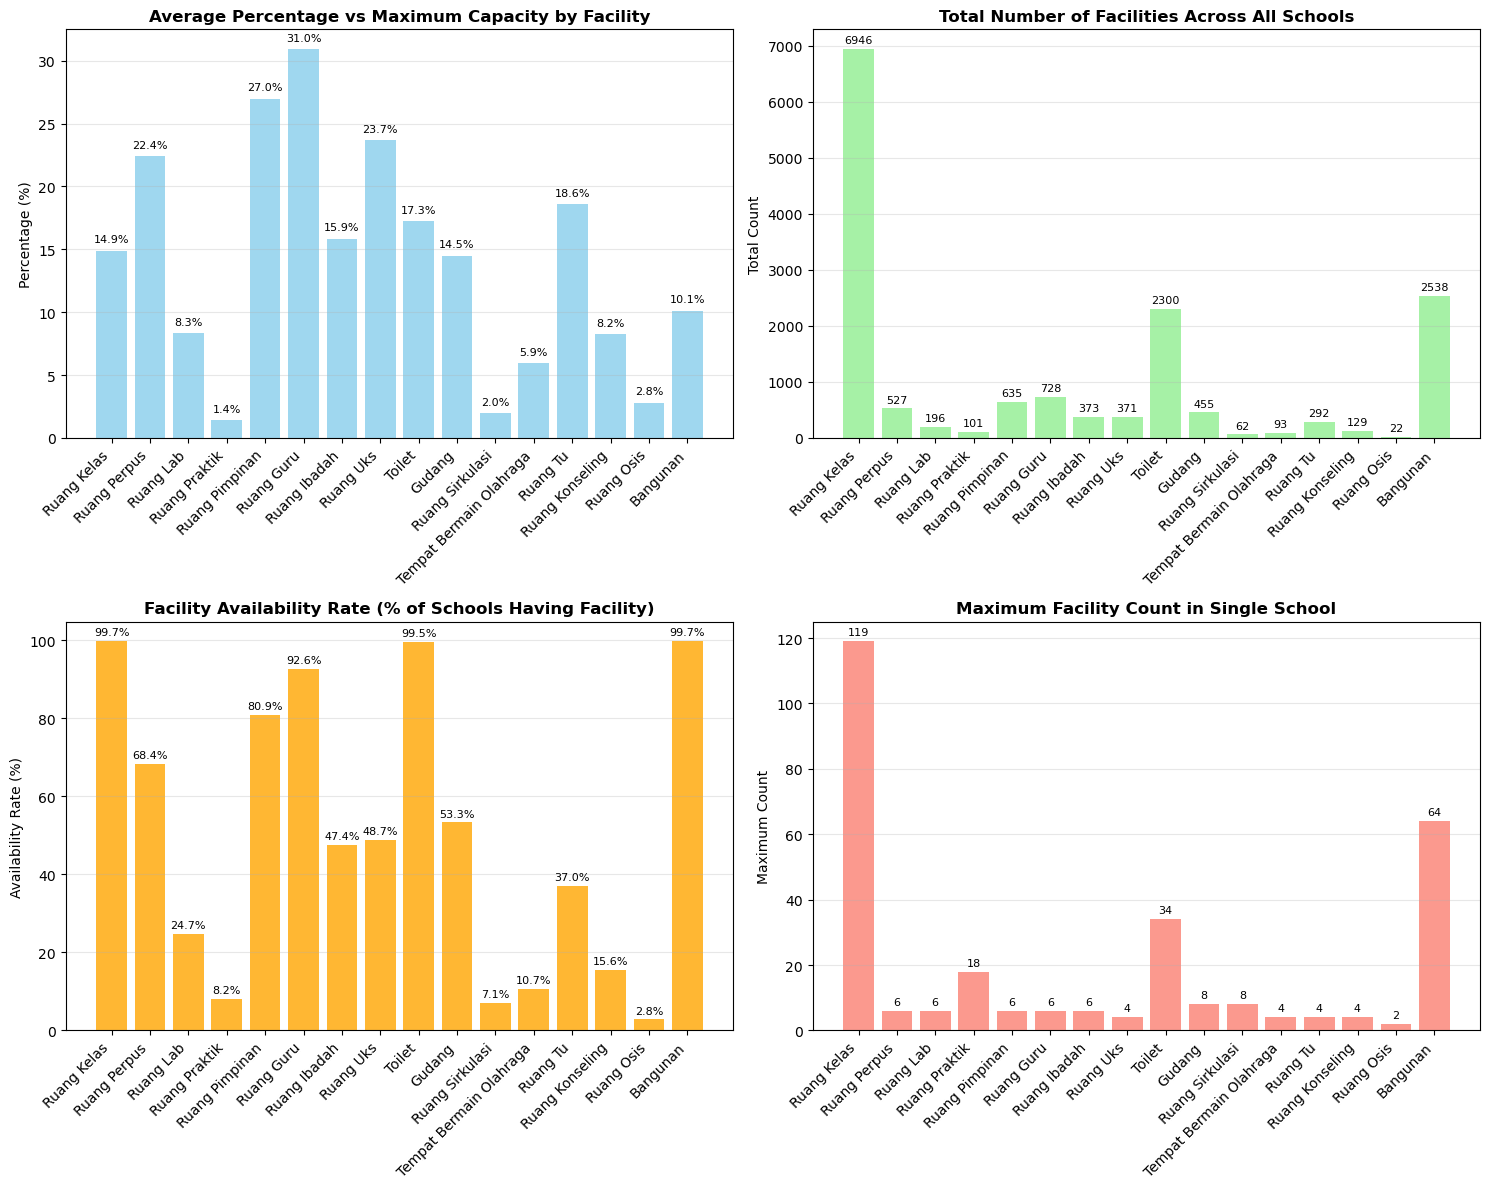

In [13]:
# Create DataFrame for easier visualization
facility_summary_df = pd.DataFrame.from_dict(facility_percentages, orient='index')

print("\nFACILITY SUMMARY TABLE:")
print("="*100)
display_df = facility_summary_df[['facility_name', 'total_facilities', 'max_count', 
                                  'mean_count', 'avg_percentage_vs_max', 
                                  'schools_with_facility', 'schools_without_facility']].round(2)
print(display_df.to_string())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average Percentage vs Maximum
ax1 = axes[0, 0]
facility_names = [stats['facility_name'] for stats in facility_percentages.values()]
avg_percentages = [stats['avg_percentage_vs_max'] for stats in facility_percentages.values()]

bars1 = ax1.bar(range(len(facility_names)), avg_percentages, color='skyblue', alpha=0.8)
ax1.set_title('Average Percentage vs Maximum Capacity by Facility', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(range(len(facility_names)))
ax1.set_xticklabels(facility_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 2. Total Facilities Count
ax2 = axes[0, 1]
total_facilities = [stats['total_facilities'] for stats in facility_percentages.values()]

bars2 = ax2.bar(range(len(facility_names)), total_facilities, color='lightgreen', alpha=0.8)
ax2.set_title('Total Number of Facilities Across All Schools', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Count')
ax2.set_xticks(range(len(facility_names)))
ax2.set_xticklabels(facility_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(total_facilities)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# 3. Facility Availability Rate
ax3 = axes[1, 0]
availability_rates = [(stats['schools_with_facility']/stats['total_schools']*100) 
                     for stats in facility_percentages.values()]

bars3 = ax3.bar(range(len(facility_names)), availability_rates, color='orange', alpha=0.8)
ax3.set_title('Facility Availability Rate (% of Schools Having Facility)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Availability Rate (%)')
ax3.set_xticks(range(len(facility_names)))
ax3.set_xticklabels(facility_names, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 4. Maximum Capacity by Facility
ax4 = axes[1, 1]
max_counts = [stats['max_count'] for stats in facility_percentages.values()]

bars4 = ax4.bar(range(len(facility_names)), max_counts, color='salmon', alpha=0.8)
ax4.set_title('Maximum Facility Count in Single School', fontsize=12, fontweight='bold')
ax4.set_ylabel('Maximum Count')
ax4.set_xticks(range(len(facility_names)))
ax4.set_xticklabels(facility_names, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + max(max_counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
def calculate_detailed_percentages(df):
    """
    Calculate detailed percentages for each school and facility
    Logic: (current_facility_count / max_facility_count_across_all_schools) * 100%
    Using BEFORE + AFTER values combined
    """
    
    # Define facility types (without before/after prefix)
    facility_types = [
        'ruang_kelas', 'ruang_perpus', 'ruang_lab',
        'ruang_praktik', 'ruang_pimpinan', 'ruang_guru',
        'ruang_ibadah', 'ruang_uks', 'toilet',
        'gudang', 'ruang_sirkulasi', 'tempat_bermain_olahraga',
        'ruang_tu', 'ruang_konseling', 'ruang_osis', 'bangunan'
    ]
    
    # Create a copy of the dataframe for calculations
    df_calc = df.copy()
    
    # Calculate total facilities (before + after) and percentage for each facility type
    for facility_type in facility_types:
        before_col = f'before_{facility_type}'
        after_col = f'after_{facility_type}'
        total_col = f'total_{facility_type}'
        
        if before_col in df_calc.columns and after_col in df_calc.columns:
            # Calculate total facilities (before + after)
            df_calc[total_col] = df_calc[before_col].fillna(0) + df_calc[after_col].fillna(0)
            
            # Get max value across all schools (excluding null values)
            max_value = df_calc[total_col].max()
            
            if max_value > 0:
                # Calculate percentage: (total_count / max_count) * 100
                df_calc[f'{total_col}_percentage'] = (df_calc[total_col] / max_value) * 100
            else:
                df_calc[f'{total_col}_percentage'] = 0
            
            # Fill null values with 0
            df_calc[f'{total_col}_percentage'] = df_calc[f'{total_col}_percentage'].fillna(0)
    
    return df_calc

# Calculate detailed percentages
df_with_percentages = calculate_detailed_percentages(df)

# Show sample calculations for verification
print("SAMPLE PERCENTAGE CALCULATIONS (BEFORE + AFTER)")
print("="*80)
print("Showing first 5 schools with their facility counts and percentages:")
print()

sample_schools = df_with_percentages[['sekolah', 'kabupaten', 'kecamatan']].head()

for idx in sample_schools.index[:5]:
    school_name = df_with_percentages.loc[idx, 'sekolah']
    kabupaten = df_with_percentages.loc[idx, 'kabupaten']
    kecamatan = df_with_percentages.loc[idx, 'kecamatan']
    
    print(f"\nSekolah: {school_name}")
    print(f"Lokasi: {kecamatan}, {kabupaten}")
    print("-" * 60)
    
    # Show facility counts and percentages
    facility_types = [
        'ruang_kelas', 'ruang_perpus', 'ruang_lab',
        'ruang_praktik', 'ruang_pimpinan', 'ruang_guru'
    ]
    
    for facility_type in facility_types:
        before_col = f'before_{facility_type}'
        after_col = f'after_{facility_type}'
        total_col = f'total_{facility_type}'
        
        if all(col in df_with_percentages.columns for col in [before_col, after_col, total_col]):
            before_count = df_with_percentages.loc[idx, before_col] or 0
            after_count = df_with_percentages.loc[idx, after_col] or 0
            total_count = df_with_percentages.loc[idx, total_col]
            percentage = df_with_percentages.loc[idx, f'{total_col}_percentage']
            max_val = df_with_percentages[total_col].max()
            
            facility_name = facility_type.replace('_', ' ').title()
            print(f"{facility_name:20}: {before_count:2.0f} + {after_count:2.0f} = {total_count:3.0f} / {max_val:3.0f} = {percentage:6.2f}%")

print(f"\n\nTotal schools analyzed: {len(df_with_percentages)}")
print(f"Facilities calculated: {len([col for col in df_with_percentages.columns if col.endswith('_percentage')])}")

SAMPLE PERCENTAGE CALCULATIONS (BEFORE + AFTER)
Showing first 5 schools with their facility counts and percentages:


Sekolah: SLB SAMUDRA LAVENDER
Lokasi: Kec. Bangkalan, Kab. Bangkalan
------------------------------------------------------------
Ruang Kelas         :  8 +  0 =   8 / 119 =   6.72%
Ruang Perpus        :  1 +  0 =   1 /   6 =  16.67%
Ruang Lab           :  0 +  0 =   0 /   6 =   0.00%
Ruang Praktik       :  0 +  0 =   0 /  18 =   0.00%
Ruang Pimpinan      :  1 +  0 =   1 /   6 =  16.67%
Ruang Guru          :  1 +  0 =   1 /   6 =  16.67%

Sekolah: SLB PGRI
Lokasi: Kec. Kamal, Kab. Bangkalan
------------------------------------------------------------
Ruang Kelas         :  7 +  7 =  14 / 119 =  11.76%
Ruang Perpus        :  1 +  1 =   2 /   6 =  33.33%
Ruang Lab           :  0 +  0 =   0 /   6 =   0.00%
Ruang Praktik       :  0 +  0 =   0 /  18 =   0.00%
Ruang Pimpinan      :  1 +  1 =   2 /   6 =  33.33%
Ruang Guru          :  1 +  1 =   2 /   6 =  33.33%

Sekolah: SLB

In [15]:
# Create summary statistics by region
print("\nSUMMARY BY KABUPATEN/KOTA (BEFORE + AFTER)")
print("="*100)

# Group by kabupaten and calculate average percentages
percentage_columns = [col for col in df_with_percentages.columns if col.endswith('_percentage') and 'total_' in col]

regional_summary = df_with_percentages.groupby('kabupaten')[percentage_columns].agg({
    col: ['mean', 'std', 'min', 'max'] for col in percentage_columns
}).round(2)

# Flatten column names
regional_summary.columns = ['_'.join(col).strip() for col in regional_summary.columns.values]

# Show top 5 kabupaten by average facility percentage
facility_avg_cols = [col for col in regional_summary.columns if col.endswith('_mean')]
regional_summary['overall_avg'] = regional_summary[facility_avg_cols].mean(axis=1)

top_regions = regional_summary.nlargest(5, 'overall_avg')
print("Top 5 Kabupaten/Kota by Average Facility Percentage (Before + After):")
print(top_regions[['overall_avg']].to_string())

print("\n" + "="*100)
print("FACILITY PERCENTAGE DISTRIBUTION SUMMARY (BEFORE + AFTER)")
print("="*100)

# Calculate overall statistics for each facility type
for facility in ['total_ruang_kelas', 'total_ruang_perpus', 'total_ruang_lab', 'total_ruang_pimpinan']:
    if f'{facility}_percentage' in df_with_percentages.columns:
        facility_name = facility.replace('total_', '').replace('_', ' ').title()
        percentages = df_with_percentages[f'{facility}_percentage']
        
        print(f"\n{facility_name} (Before + After):")
        print(f"  Average: {percentages.mean():.2f}%")
        print(f"  Median: {percentages.median():.2f}%")
        print(f"  Std Dev: {percentages.std():.2f}%")
        print(f"  Min: {percentages.min():.2f}%")
        print(f"  Max: {percentages.max():.2f}%")
        print(f"  Schools at 100%: {len(percentages[percentages == 100])}")
        print(f"  Schools at 0%: {len(percentages[percentages == 0])}")

# Show comparison between before vs after for some facilities
print("\n" + "="*100)
print("COMPARISON: BEFORE vs AFTER vs TOTAL")
print("="*100)

for facility_type in ['ruang_kelas', 'ruang_perpus', 'ruang_lab', 'toilet']:
    before_col = f'before_{facility_type}'
    after_col = f'after_{facility_type}'
    total_col = f'total_{facility_type}'
    
    if all(col in df_with_percentages.columns for col in [before_col, after_col, total_col]):
        facility_name = facility_type.replace('_', ' ').title()
        
        before_sum = df_with_percentages[before_col].sum()
        after_sum = df_with_percentages[after_col].sum()
        total_sum = df_with_percentages[total_col].sum()
        
        print(f"\n{facility_name}:")
        print(f"  Total BEFORE across all schools: {before_sum}")
        print(f"  Total AFTER across all schools: {after_sum}")
        print(f"  Total COMBINED: {total_sum}")
        print(f"  After as % of total: {(after_sum/total_sum*100) if total_sum > 0 else 0:.1f}%")

# Option to save results to CSV
save_option = input("\nDo you want to save the results to CSV? (y/n): ")
if save_option.lower() == 'y':
    # Save detailed results
    output_file = '../output/facility_percentages_detailed_before_after.csv'
    df_with_percentages.to_csv(output_file, index=False)
    print(f"Detailed results saved to: {output_file}")
    
    # Save summary results
    summary_file = '../output/facility_percentages_summary_before_after.csv'
    facility_summary_df.to_csv(summary_file)
    print(f"Summary results saved to: {summary_file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE! (BEFORE + AFTER METHOD)")
print("="*80)


SUMMARY BY KABUPATEN/KOTA (BEFORE + AFTER)
Top 5 Kabupaten/Kota by Average Facility Percentage (Before + After):
                 overall_avg
kabupaten                   
Kota Pasuruan      31.640625
Kab. Trenggalek    22.498125
Kota Kediri        21.537500
Kab. Ponorogo      18.998750
Kab. Jombang       18.616875

FACILITY PERCENTAGE DISTRIBUTION SUMMARY (BEFORE + AFTER)

Ruang Kelas (Before + After):
  Average: 14.89%
  Median: 11.76%
  Std Dev: 12.31%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 1

Ruang Perpus (Before + After):
  Average: 22.41%
  Median: 33.33%
  Std Dev: 16.87%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 2
  Schools at 0%: 124

Ruang Lab (Before + After):
  Average: 8.33%
  Median: 0.00%
  Std Dev: 15.86%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 295

Ruang Pimpinan (Before + After):
  Average: 27.00%
  Median: 33.33%
  Std Dev: 15.32%
  Min: 0.00%
  Max: 100.00%
  Schools at 100%: 1
  Schools at 0%: 75

COMPARISON

In [16]:
def calculate_overall_facility_score(df):
    """
    Calculate overall facility score for each school
    Average of all facility percentages (BEFORE + AFTER)
    """
    # Get columns that end with '_percentage' and contain 'total_'
    percentage_columns = [col for col in df.columns if col.endswith('_percentage') and 'total_' in col]
    
    # Calculate overall score as average of all facility percentages
    df['overall_facility_score'] = df[percentage_columns].mean(axis=1)
    
    return df

# Calculate overall scores
df_with_scores = calculate_overall_facility_score(df_with_percentages)

# Create comprehensive school ranking
print("DAFTAR SEMUA SEKOLAH DENGAN PERSENTASE FASILITAS (BEFORE + AFTER)")
print("="*120)
print("Diurutkan dari persentase fasilitas tertinggi ke terendah")
print("="*120)

# Select relevant columns for display
school_ranking = df_with_scores[[
    'sekolah', 'kabupaten', 'kecamatan', 'overall_facility_score',
    'total_ruang_kelas_percentage', 'total_ruang_perpus_percentage', 
    'total_ruang_lab_percentage', 'total_ruang_praktik_percentage',
    'total_ruang_pimpinan_percentage', 'total_ruang_guru_percentage',
    'total_ruang_ibadah_percentage', 'total_ruang_uks_percentage',
    'total_toilet_percentage', 'total_gudang_percentage'
]].copy()

# Sort by overall facility score (highest first)
school_ranking = school_ranking.sort_values('overall_facility_score', ascending=False)

# Display results with ranking
print(f"\nTotal sekolah dianalisis: {len(school_ranking)}")
print(f"Rata-rata skor fasilitas keseluruhan: {school_ranking['overall_facility_score'].mean():.2f}%")
print(f"Skor tertinggi: {school_ranking['overall_facility_score'].max():.2f}%")
print(f"Skor terendah: {school_ranking['overall_facility_score'].min():.2f}%")

print("\n" + "-"*120)
print(f"{'Rank':<5} {'Sekolah':<40} {'Lokasi':<35} {'Overall':<8} {'Kelas':<6} {'Perpus':<7} {'Lab':<5} {'Praktik':<8}")
print("-"*120)

for idx, (_, row) in enumerate(school_ranking.head(50).iterrows(), 1):
    sekolah = row['sekolah'][:37] + "..." if len(row['sekolah']) > 40 else row['sekolah']
    lokasi = f"{row['kecamatan']}, {row['kabupaten']}"[:32] + "..." if len(f"{row['kecamatan']}, {row['kabupaten']}") > 35 else f"{row['kecamatan']}, {row['kabupaten']}"
    
    print(f"{idx:<5} {sekolah:<40} {lokasi:<35} {row['overall_facility_score']:>6.1f}% {row['total_ruang_kelas_percentage']:>5.1f}% {row['total_ruang_perpus_percentage']:>6.1f}% {row['total_ruang_lab_percentage']:>4.1f}% {row['total_ruang_praktik_percentage']:>7.1f}%")

print(f"\n... (menampilkan 50 teratas dari {len(school_ranking)} sekolah)")

# Show detailed breakdown for top 10 schools
print("\n" + "="*120)
print("TOP 10 SEKOLAH DENGAN RINCIAN LENGKAP FASILITAS (BEFORE + AFTER)")
print("="*120)

top_10 = school_ranking.head(10)

for idx, (_, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{idx}. {row['sekolah']}")
    print(f"   Lokasi: {row['kecamatan']}, {row['kabupaten']}")
    print(f"   Overall Score: {row['overall_facility_score']:.2f}%")
    print("   Rincian Fasilitas:")
    
    facilities = [
        ('Ruang Kelas', 'total_ruang_kelas_percentage'),
        ('Perpustakaan', 'total_ruang_perpus_percentage'),
        ('Laboratorium', 'total_ruang_lab_percentage'),
        ('Ruang Praktik', 'total_ruang_praktik_percentage'),
        ('Ruang Pimpinan', 'total_ruang_pimpinan_percentage'),
        ('Ruang Guru', 'total_ruang_guru_percentage'),
        ('Ruang Ibadah', 'total_ruang_ibadah_percentage'),
        ('UKS', 'total_ruang_uks_percentage'),
        ('Toilet', 'total_toilet_percentage'),
        ('Gudang', 'total_gudang_percentage')
    ]
    
    for facility_name, column in facilities:
        if column in row.index:
            # Show breakdown of before + after
            facility_type = column.replace('total_', '').replace('_percentage', '')
            before_col = f'before_{facility_type}'
            after_col = f'after_{facility_type}'
            total_col = f'total_{facility_type}'
            
            if all(col in df_with_scores.columns for col in [before_col, after_col, total_col]):
                school_data = df_with_scores[df_with_scores['sekolah'] == row['sekolah']].iloc[0]
                before_val = school_data[before_col] or 0
                after_val = school_data[after_col] or 0
                total_val = school_data[total_col]
                
                print(f"     - {facility_name:<15}: {before_val:2.0f} + {after_val:2.0f} = {total_val:3.0f} ({row[column]:>6.1f}%)")
    print("   " + "-"*50)

print(f"\n{'='*120}")
print("RINGKASAN DISTRIBUSI SKOR")
print("="*120)

# Create score distribution
score_ranges = [
    (90, 100, "Sangat Baik (90-100%)"),
    (75, 89, "Baik (75-89%)"),
    (50, 74, "Cukup (50-74%)"),
    (25, 49, "Kurang (25-49%)"),
    (0, 24, "Sangat Kurang (0-24%)")
]

for min_score, max_score, category in score_ranges:
    count = len(school_ranking[
        (school_ranking['overall_facility_score'] >= min_score) & 
        (school_ranking['overall_facility_score'] <= max_score)
    ])
    percentage = (count / len(school_ranking)) * 100
    print(f"{category:<25}: {count:>4} sekolah ({percentage:>5.1f}%)")

print(f"\nTotal: {len(school_ranking)} sekolah")

DAFTAR SEMUA SEKOLAH DENGAN PERSENTASE FASILITAS (BEFORE + AFTER)
Diurutkan dari persentase fasilitas tertinggi ke terendah

Total sekolah dianalisis: 392
Rata-rata skor fasilitas keseluruhan: 14.00%
Skor tertinggi: 53.58%
Skor terendah: 0.00%

------------------------------------------------------------------------------------------------------------------------
Rank  Sekolah                                  Lokasi                              Overall  Kelas  Perpus  Lab   Praktik 
------------------------------------------------------------------------------------------------------------------------
1     SLB BHAKTI LUHUR                         Kec. Sukun, Kota Malang               53.6%  58.8%   33.3% 33.3%    44.4%
2     SLBN PEMBINA TINGKAT NASIONAL BAGIAN ... Kec. Lawang, Kab. Malang              50.9%  52.1%   33.3% 66.7%   100.0%
3     SLB TUNAS HARAPAN I TEMBELANG            Kec. Tembelang, Kab. Jombang          49.3%  13.4%   33.3% 100.0%     0.0%
4     SLB NEGERI 2 KOTA PAS